# Caffe LSTM Example on Sin(t) Waveform Prediction
- Network & Solver definition
- Mini-Batch Training & Testing
- Inifnite time sequence inference
- Iterative Finetuning

Example based on http://www.xiaoliangbai.com/2018/01/30/Caffe-LSTM-SinWaveform-Batch by Xiaoliang Bai.<br>


In [1]:
import numpy as np
import math
import os
import caffe
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# change this to use GPU acceleration
#GPU_ID = 0
#caffe.set_mode_gpu()
#caffe.set_device(GPU_ID)
caffe.set_mode_cpu()

%load_ext autoreload
%autoreload 2

In [2]:
# Use the sample generator from Tensorflow Sin(t) online
def generate_sample(f = 1.0, t0 = None, batch_size = 1, predict = 50, samples = 100):
    """
    Generates data samples.

    :param f: The frequency to use for all time series or None to randomize.
    :param t0: The time offset to use for all time series or None to randomize.
    :param batch_size: The number of time series to generate.
    :param predict: The number of future samples to generate.
    :param samples: The number of past (and current) samples to generate.
    :return: Tuple that contains the past times and values as well as the future times and values. In all outputs,
             each row represents one time series of the batch.
    """
    Fs = 100.0

    T = np.empty((batch_size, samples))
    Y = np.empty((batch_size, samples))
    FT = np.empty((batch_size, predict))
    FY = np.empty((batch_size, predict))

    _t0 = t0
    for i in range(batch_size):
        t = np.arange(0, samples + predict) / Fs
        if _t0 is None:
            t0 = np.random.rand() * 2 * np.pi
        else:
            t0 = _t0 + i/float(batch_size)

        freq = f
        if freq is None:
            freq = np.random.rand() * 3.5 + 0.5

        y = np.sin(2 * np.pi * freq * (t + t0))

        T[i, :] = t[0:samples]
        Y[i, :] = y[0:samples]

        FT[i, :] = t[samples:samples + predict]
        FY[i, :] = y[samples:samples + predict]

    return T, Y, FT, FY

In [3]:
net_path = 'lstm_demo_network.train.prototxt'
inference_path = 'lstm_demo_network.deploy.prototxt'
solver_config_path = 'lstm_demo_solver.prototxt'
snapshot_prefix = 'lstm_demo_snapshot'
# Network Parameters
n_input = 1 # single input stream
n_steps = 100 # timesteps
n_hidden = 15 # hidden units in LSTM
n_outputs = 50 # predictions in future time
batch_size = 20 # batch of data
NO_INPUT_DATA = -2 # defined numeric value for network if no input data is available
# Training Parameters
n_train = 3000
n_display = 200
n_adamAlpha = 0.002

## Training Network definition

In [4]:
#define and save the network
from caffe import layers as L, params as P
def gen_network(n_steps,n_outputs,batch_size,n_input):
    n = caffe.NetSpec()
    # the network is trained on a time series of n_steps + n_outputs
    
    # we have input data for n_steps, which the network needs to keep tracing for n_output more steps
    # labels are given for n_output steps for loss calculation
    
    # a third input (clip) gives a mask for the first element in each time series.
    # this seems cumbersome but it allows training on series longer than the unrolled network size
    # as well as inference on infinite sequences
    
    # the data shape for caffe LSTM/RNN layers is always T x B x ... where T is the timestep and B are
    # independent data series (for example multiple batches)
    n.data, n.label, n.clip = L.Input( shape=[ dict(dim=[n_steps,batch_size,n_input]),
                                           dict(dim=[n_outputs,batch_size,n_input]),
                                           dict(dim=[n_steps+n_outputs,batch_size]) ],ntop=3)

    # the data layer size must match the size of the unrolled network, as such we concatenate with dummy-values
    # indicating that no more input data is available beyond n_steps
    n.dummy=L.DummyData( data_filler=dict(type="constant",value = NO_INPUT_DATA),
                        shape=[ dict(dim=[n_outputs,batch_size,n_input]) ] )
    n.fulldata=L.Concat(n.data, n.dummy, axis=0)
    # the lstm layer with n_hidden neurons
    n.lstm1 = L.LSTM(n.fulldata, n.clip,
                     recurrent_param = dict(num_output=n_hidden,
                                            weight_filler = dict(type='gaussian', std=0.05),
                                            bias_filler = dict(type='constant',value=0)))
    # usually followed by a fully connected output layer
    n.ip1 = L.InnerProduct(n.lstm1, num_output=1, bias_term=True, axis=2,
                           weight_filler=dict(type='gaussian',mean=0,std=0.1))
    
    # in this implementation, the loss is calculated over
    # the entire time series, not just the predicted future
    n.fulllabel=L.Concat(n.data,n.label, axis=0)
    n.loss = L.EuclideanLoss(n.ip1,n.fulllabel)
    
    ns=n.to_proto()
    with open(net_path, 'w') as f:
        f.write(str(ns))

gen_network(n_steps, n_outputs, batch_size, n_input)

## Solver definition

In [5]:
#standard Adam solver
def gen_solver():
    sd = caffe.proto.caffe_pb2.SolverParameter()
    sd.random_seed = 0xCAFFE
    sd.train_net = net_path
    sd.test_net.append(net_path)
    sd.test_interval = 500  #
    sd.test_iter.append(100)
    sd.max_iter = n_train
    sd.snapshot = n_train
    sd.display = n_display
    sd.snapshot_prefix = snapshot_prefix
    sd.solver_mode = caffe.proto.caffe_pb2.SolverParameter.CPU
    sd.type = 'Adam'
    sd.lr_policy = 'fixed'
    sd.base_lr = n_adamAlpha

    with open(solver_config_path, 'w') as f:
        f.write(str(sd))
gen_solver()

### load the solver and create train and test nets
solver = caffe.get_solver(solver_config_path)

## LSTM specific weight initialisation

In [6]:
def init_weights(solver):
    # Initialize forget gate bias to 1
    #
    # from include/caffe/layers/lstm_layer.hpp:
    #/***
    # * The specific architecture used in this implementation is as described in
    # * "Learning to Execute" [arXiv:1410.4615], reproduced below:
    # *     i_t := \sigmoid[ W_{hi} * h_{t-1} + W_{xi} * x_t + b_i ]
    # *     f_t := \sigmoid[ W_{hf} * h_{t-1} + W_{xf} * x_t + b_f ]
    # *     o_t := \sigmoid[ W_{ho} * h_{t-1} + W_{xo} * x_t + b_o ]
    # *     g_t :=    \tanh[ W_{hg} * h_{t-1} + W_{xg} * x_t + b_g ]
    # *     c_t := (f_t .* c_{t-1}) + (i_t .* g_t)
    # *     h_t := o_t .* \tanh[c_t]
    # * In the implementation, the i, f, o, and g computations are performed as a
    # * single inner product.
    # ***/
    #
    # Weights and Biases are stored as a blob of size 4 * n_hidden
    # in order i,f,o,g the caffe LSTM implementation
    # As such [ n_hidden : 2 * n_hidden ] addresses the forget gates
    #
    # This is a common trick to speed up LSTM training.
    # Unfortunately Caffe does not offer selective weight initialisation in the layer definition.
    solver.net.params['lstm1'][1].data[n_hidden : 2 * n_hidden] = 1

init_weights(solver)

## Training

step  0 , loss =  4.97560691833
step  200 , loss =  1.77669882774
step  400 , loss =  1.8116029501
step  600 , loss =  1.55030608177
step  800 , loss =  0.41143772006
step  1000 , loss =  0.200723454356
step  1200 , loss =  0.281178236008
step  1400 , loss =  0.310991555452
step  1600 , loss =  0.176904827356
step  1800 , loss =  0.123902663589
step  2000 , loss =  0.121620900929
step  2200 , loss =  0.299288928509
step  2400 , loss =  0.388235569
step  2600 , loss =  0.0680060610175
step  2800 , loss =  0.0505336821079
Finished training, iteration reached 3000
saving snapshot to "lstm_demo_snapshot_iter_3000.caffemodel"


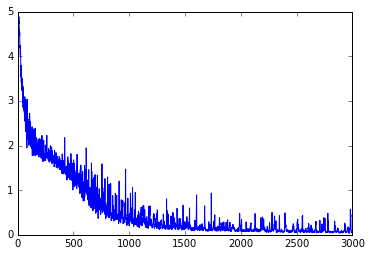

In [7]:
# Train network
def train_single(solver, niter, disp_step):
    train_loss = np.zeros(niter) # this is for plotting, later
    
    # the first entry in each time series has its clip mask set to 0
    clipmask = np.ones((n_steps+n_outputs,batch_size))
    clipmask[0,:] = np.zeros((batch_size))
    for i in range(niter):
        _, batch_x, _, batch_y = generate_sample(f=None,
                                         t0=None,
                                         batch_size=batch_size,
                                         samples=n_steps,
                                         predict=n_outputs)
        # IMPORTANT: Caffe LSTM has time in first dimension and batch in second, so
        # batched training data needs to be transposed
        batch_x = batch_x.transpose()
        batch_y = batch_y.transpose()
        solver.net.blobs['label'].data[:,:,0] = batch_y
        solver.net.blobs['data'].data[:,:,0]  = batch_x
        solver.net.blobs['clip'].data[:,:] = clipmask
        solver.step(1)
        train_loss[i] = solver.net.blobs['loss'].data
        if i % disp_step == 0:
            print "step ", i, ", loss = ", train_loss[i]
    print "Finished training, iteration reached", niter
    return train_loss

train_loss = train_single(solver,n_train,n_display)
#explicitly save snapshot if it has not been done yet
print 'saving snapshot to "%s_iter_%i.caffemodel"' % (snapshot_prefix,n_train)
solver.snapshot()
# plot loss value during training
plt.plot(np.arange(n_train), train_loss)
plt.show()

## Testing

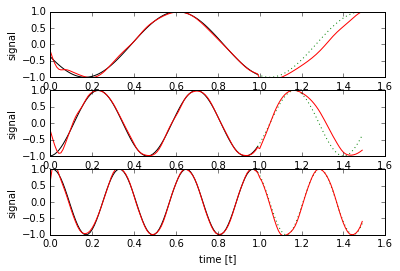

In [8]:
# Test the prediction with trained (unrolled) net
# we can change the batch size on the network at runtime, but not the number of timesteps (depth of unrolling)
def test_net(net,n_tests):
    batch_size = 1
    net.blobs['data'].reshape(n_steps, batch_size, n_input)
    net.blobs['label'].reshape(n_outputs, batch_size, n_input)
    net.blobs['clip'].reshape(n_steps+n_outputs, batch_size)
    net.blobs['dummy'].reshape(n_outputs, batch_size, n_input)
    net.reshape()

    clipmask = np.ones((n_steps+n_outputs,batch_size))
    clipmask[0,:] = np.zeros(batch_size)

    for i in range(1, n_tests + 1):
        plt.subplot(n_tests, 1, i)
        t, y, next_t, expected_y = generate_sample(f=i+0.1337, t0=None, samples=n_steps, predict=n_outputs)
        test_input = y.transpose()
        expected_y = expected_y.reshape(n_outputs)
        net.blobs['data'].data[:,:,0]  = test_input
        net.blobs['clip'].data[:,:] = clipmask
        net.forward()
        prediction = net.blobs['ip1'].data

        # remove the batch size dimensions
        t = t.squeeze()
        y = y.squeeze()
        next_t = next_t.squeeze()
        t2 = np.append(t,next_t)
        prediction = prediction.squeeze()
        
        plt.plot(t, y, color='black')
        plt.plot(np.append(t[-1], next_t), np.append(y[-1], expected_y), color='green', linestyle=":")
        plt.plot(t2, prediction, color='red')
        plt.ylim([-1, 1])
        plt.xlabel('time [t]')
        plt.ylabel('signal')
    plt.show()
test_net(solver.test_nets[0],3)

## Network definition for infinite length sequence inference:

In [9]:
#generate inference single time step network
def gen_deploy_network(n_input):
    n = caffe.NetSpec()
    # This network has only scalar input and output data 
    # No unrolling takes place, as such the length of each time series is 1
    # No batch processing either (batch size is 1)
    # The beginning of a new series (discarding LSTM hidden data) is indicated through the clip flag
    n.data, n.clip = L.Input( shape=[ dict(dim=[1,1,n_input]),
                                           dict(dim=[1,1]) ],ntop=2)
    n.lstm1 = L.LSTM(n.data, n.clip,
                     recurrent_param = dict(num_output=n_hidden,
                                            weight_filler = dict(type='uniform',min=-0.08,max=0.08)))
    n.ip1 = L.InnerProduct(n.lstm1, num_output=1, bias_term=True, axis=2,
                           weight_filler=dict(type='gaussian',mean=0,std=0.1))
    # n.ip1 is the output layer
    # there is no loss layer and no loss calculation
    # this network is extremely small and performant, compared to the unrolled training network
    ns=n.to_proto()
    return ns

ns = gen_deploy_network(n_input)
with open(inference_path, 'w') as f:
    f.write(str(ns))

# load Network with weights from previously trained network
# alternatively the network could be loaded without weights and then explicitly assigned (copied) layer by layer
print 'loading snapshot from "%s_iter_%i.caffemodel"' % (snapshot_prefix,n_train)
net = caffe.Net(inference_path,caffe.TEST,weights='%s_iter_%i.caffemodel'%(snapshot_prefix,n_train))

loading snapshot from "lstm_demo_snapshot_iter_3000.caffemodel"


## Inference / Validation

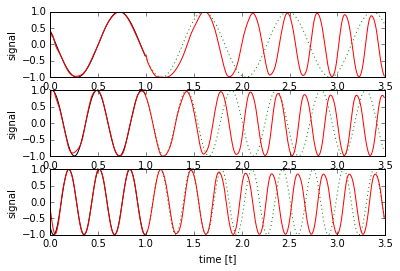

In [10]:
# the single step network can process infinite time series in a loop,
# as such we can increate n_outputs safely to have a glance at long term behaviour

def test_net_iterative(net,n_tests,n_outputs):
    for i in range(1, n_tests + 1):
        plt.subplot(n_tests, 1, i)
        t, y, next_t, expected_y = generate_sample(f=i+0.1337, t0=None, samples=n_steps, predict=n_outputs)
        expected_y = expected_y.reshape(n_outputs)

        net.blobs['clip'].data[0,0]=0
        prediction = []
        for T in range(n_steps):
            net.blobs['data'].data[0,0,0] = y[0,T]
            net.forward()
            prediction.append(net.blobs['ip1'].data[0,0,0])
            net.blobs['clip'].data[0,0]=1
        
        for T in range(n_outputs):
            # in this case we have to manually indicate to the network
            # that there is no more input data at the current time step
            net.blobs['data'].data[0,0,0] = NO_INPUT_DATA
            net.forward()
            prediction.append(net.blobs['ip1'].data[0,0,0])
            net.blobs['clip'].data[0,0]=1
        
        # remove the batch size dimensions
        t = t.squeeze()
        y = y.squeeze()
        next_t = next_t.squeeze()
        t2 = np.append(t,next_t)
        prediction = np.array(prediction)
        
        plt.plot(t, y, color='black')
        plt.plot(np.append(t[-1], next_t), np.append(y[-1], expected_y), color='green', linestyle=":")
        plt.plot(t2, prediction, color='red')
        plt.ylim([-1, 1])
        plt.xlabel('time [t]')
        plt.ylabel('signal')
    plt.show()

test_net_iterative(net,3,250)

### Observation:
The network drifts towards a generic sine wave when let running for longer than the training sample size.
What happens if we train with a longer training window?

step  0 , loss =  5.01189613342
step  200 , loss =  3.47609949112
step  400 , loss =  3.33659029007
step  600 , loss =  3.02057051659
step  800 , loss =  2.99181032181
step  1000 , loss =  2.6724998951
step  1200 , loss =  2.59029340744
step  1400 , loss =  3.30251193047
step  1600 , loss =  2.29588937759
step  1800 , loss =  1.79781186581
step  2000 , loss =  2.1812479496
step  2200 , loss =  2.23203825951
step  2400 , loss =  1.92201602459
step  2600 , loss =  1.43512129784
step  2800 , loss =  1.50735723972
step  3000 , loss =  1.76155400276
step  3200 , loss =  1.62861597538
step  3400 , loss =  0.875917136669
step  3600 , loss =  1.4759581089
step  3800 , loss =  0.907884716988
step  4000 , loss =  1.79176986217
step  4200 , loss =  0.56052428484
step  4400 , loss =  1.33801186085
step  4600 , loss =  1.04612147808
step  4800 , loss =  0.959304392338
step  5000 , loss =  1.35527694225
step  5200 , loss =  0.60820376873
step  5400 , loss =  0.368702471256
step  5600 , loss =  1.076

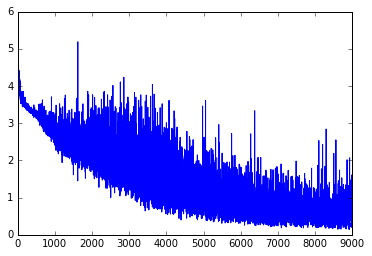

In [11]:
n_outputs = 200
n_train = 9000
net_path = 'lstm_demo_network2.train.prototxt'
solver_config_path = 'lstm_demo2_solver.prototxt'
snapshot_prefix = 'lstm_demo2_snapshot'

gen_network(n_steps, n_outputs, batch_size, n_input)
gen_solver()
solver = caffe.get_solver(solver_config_path)
init_weights(solver)
train_loss = train_single(solver,n_train,n_display)
plt.plot(np.arange(n_train), train_loss)
plt.show()

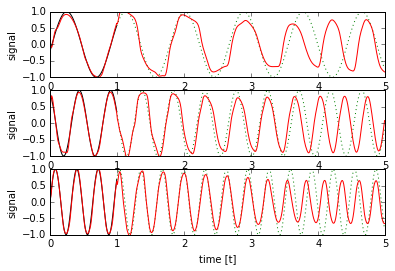

In [12]:
net.copy_from('%s_iter_%i.caffemodel'%(snapshot_prefix,n_train))
test_net_iterative(net,3,400)

### Observation:
With the longer unrolling window, the training converges much slower. The loss accumulated at the end of the window needs to backpropagate many steps until it reaches a timestep in which there is still a useful memory in the LSTM layer. On the other hand there is a much stronger local gradient towards a local minima. Under euclidian loss, a zero line has always less error than a strong but wrong signal. Any phase shift enforces drift towards 0.

This could be avoided with a loss calculation that enforces a non zero signal, but without writing a custom loss layer we need another mitigation.

We can address this with incremental increase in sequence length and finetuning:

## Iterative finetuning

initial training
step  0 , loss =  4.87693691254
step  200 , loss =  2.04052782059
step  400 , loss =  1.33015954494
step  600 , loss =  0.990258991718
step  800 , loss =  0.48339086771
step  1000 , loss =  0.292421936989
step  1200 , loss =  0.276065081358
step  1400 , loss =  0.293390631676
step  1600 , loss =  0.13360722363
step  1800 , loss =  0.125816598535
step  2000 , loss =  0.0979309678078
step  2200 , loss =  0.107035443187
step  2400 , loss =  0.0729962065816
step  2600 , loss =  0.0648237466812
step  2800 , loss =  0.15353128314
Finished training, iteration reached 3000


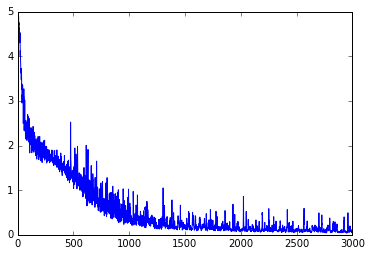

finetuning with doubled output length
step  0 , loss =  0.956134080887
step  200 , loss =  0.658028006554
step  400 , loss =  0.291369557381
step  600 , loss =  0.685518801212
step  800 , loss =  0.198832511902
step  1000 , loss =  0.639209926128
step  1200 , loss =  0.386640012264
step  1400 , loss =  0.304677337408
step  1600 , loss =  0.436783760786
step  1800 , loss =  0.19093208015
step  2000 , loss =  0.301017671824
step  2200 , loss =  0.326170057058
step  2400 , loss =  0.337538689375
step  2600 , loss =  0.13670642674
step  2800 , loss =  0.206311091781
Finished training, iteration reached 3000


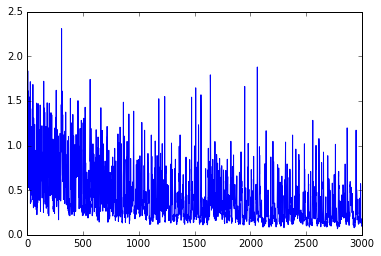

finetuning with 4 times output length
step  0 , loss =  2.47101855278
step  200 , loss =  1.20360088348
step  400 , loss =  0.705224871635
step  600 , loss =  1.58190751076
step  800 , loss =  1.45491683483
step  1000 , loss =  0.928178906441
step  1200 , loss =  2.22659778595
step  1400 , loss =  0.842435240746
step  1600 , loss =  2.03181409836
step  1800 , loss =  0.784175097942
step  2000 , loss =  1.56944930553
step  2200 , loss =  1.34631896019
step  2400 , loss =  0.840781033039
step  2600 , loss =  1.49792027473
step  2800 , loss =  0.713260054588
Finished training, iteration reached 3000


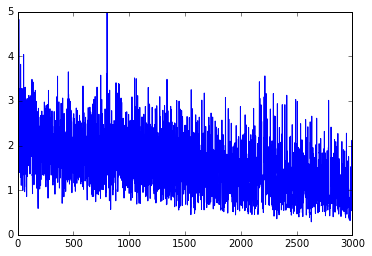

In [15]:
n_outputs = 50
n_train = 3000
net_path = 'lstm_demo3_network.train.prototxt' # same as first
solver_config_path = 'lstm_demo3_solver.prototxt'
snapshot_prefix = 'lstm_demo3_snapshot'

print "initial training"
gen_network(n_steps, n_outputs, batch_size, n_input)
gen_solver()
solver = caffe.get_solver(solver_config_path)
init_weights(solver)
train_loss = train_single(solver,n_train,n_display)
plt.plot(np.arange(n_train), train_loss)
plt.show()

print "finetuning with doubled output length"
n_outputs = 100
gen_network(n_steps, n_outputs, batch_size, n_input)
gen_solver()
solver = caffe.get_solver(solver_config_path)
solver.net.copy_from('%s_iter_%i.caffemodel'%(snapshot_prefix,n_train))
train_loss = train_single(solver,n_train,n_display)
plt.plot(np.arange(n_train), train_loss)
plt.show()

print "finetuning with 4 times output length"
n_outputs = 200
gen_network(n_steps, n_outputs, batch_size, n_input)
gen_solver()
solver = caffe.get_solver(solver_config_path)
solver.net.copy_from('%s_iter_%i.caffemodel'%(snapshot_prefix,n_train))
train_loss = train_single(solver,n_train,n_display)
plt.plot(np.arange(n_train), train_loss)
plt.show()

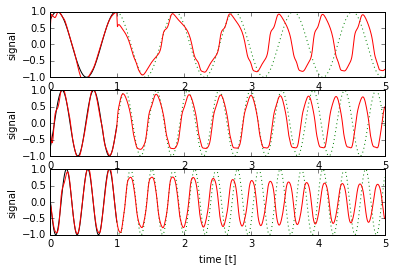

In [16]:
net.copy_from('%s_iter_%i.caffemodel'%(snapshot_prefix,n_train))
test_net_iterative(net,3,400)